In [1]:
import sys
import os
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

import random
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score

from epistatic_net.wht_sampling import SPRIGHTSample
from epistatic_net.spright_utils import SPRIGHT, make_system_simple
from utils import FourierDataset, ModelTrainer

# Set seeds
random_seed = 11
torch.manual_seed(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)

/local/agorji/minconda3/envs/spectral/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
test_k = 12
test_n = 10
test_b = 4
test_d = 5
dataset_size_coef = 1.5
test_n_samples = math.ceil(dataset_size_coef * test_n * test_k * 1.25)

dataset = FourierDataset(n=test_n, k=test_k, d=test_d, n_samples=test_n_samples)
print(sorted(dataset.get_int_freqs()))
print(dataset.X.shape)

[64, 141, 217, 266, 417, 568, 616, 620, 752, 771, 779, 868]
torch.Size([225, 10])


In [19]:
class FCN(nn.Module):
    def __init__(self, n, multiplier=2, batch_norm=False):
        super(FCN, self).__init__()
        self.fc1 = nn.Linear(n, multiplier*n)
        self.fc2 = nn.Linear(multiplier*n, multiplier*n)
        self.fc3 = nn.Linear(multiplier*n, n)
        self.fc4 = nn.Linear(n, 1)

        torch.nn.init.xavier_uniform_(self.fc1.weight)
        torch.nn.init.xavier_uniform_(self.fc2.weight)
        torch.nn.init.xavier_uniform_(self.fc3.weight)
        torch.nn.init.xavier_uniform_(self.fc4.weight)
        
        self.batch_norm = batch_norm
        if self.batch_norm:
            self.bn1 = nn.BatchNorm1d(multiplier*n)
            self.bn2 = nn.BatchNorm1d(multiplier*n)
            self.bn3 = nn.BatchNorm1d(n)

    def forward(self, x):
        if self.batch_norm:
            x = self.bn1(F.leaky_relu(self.fc1(x)))
            x = self.bn2(F.leaky_relu(self.fc2(x)))
            x = self.bn3(F.leaky_relu(self.fc3(x)))
            x = self.fc4(x)
        else:
            x = F.leaky_relu(self.fc1(x))
            x = F.leaky_relu(self.fc2(x))
            x = F.leaky_relu(self.fc3(x))
            x = self.fc4(x)

        return x.reshape(-1)

- Loded cache/N10-m4-d3-seed11/sampling-matrix-2.p from cache (sampling matrix)
- Loded cache/N10-m4-d3-seed11/sampling-matrix-0.p from cache (sampling matrix)
- Loded cache/N10-m4-d3-seed11/sampling-matrix-1.p from cache (sampling matrix)
- Loded cache/N10-m4-d3-seed11/delays-1.p from cache (delay matrix)
- Loded cache/N10-m4-d3-seed11/delays-0.p from cache (delay matrix)
- Loded cache/N10-m4-d3-seed11/delays-2.p from cache (delay matrix)
- Loded cache/N10-m4-d3-seed11/sampling-locations-0.p from cache (sampling location)
- Loded cache/N10-m4-d3-seed11/sampling-locations-1.p from cache (sampling location)
- Loded cache/N10-m4-d3-seed11/sampling-locations-2.p from cache (sampling location)


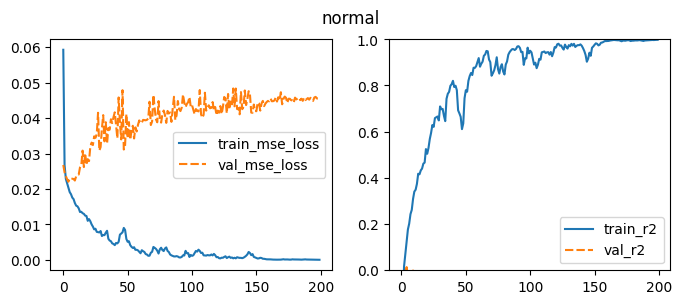

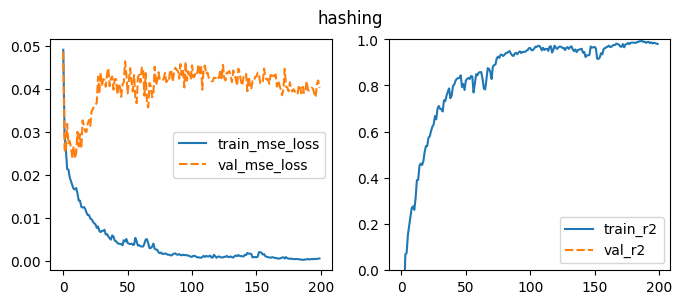

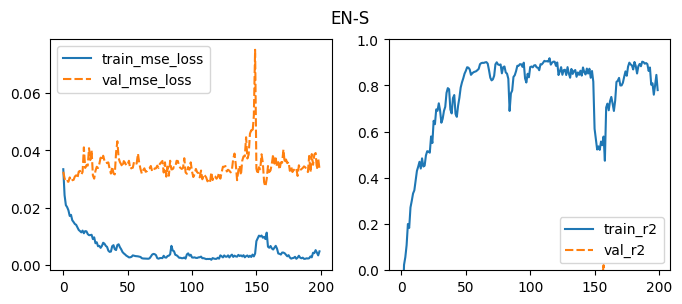

In [20]:
config = {
    "training_method": "normal",
    "add_hadamard_loss": True, 
    "n": test_n,
    "k": test_k,
    "b": test_b,
    "SPRIGHT_m": test_b,
    "SPRIGHT_d": 3,
    "rho": 0.01,
    "lr": 1e-2, 
    "weight_decay": 0, 
    "hadamard_lambda": 0.001,
    "num_epochs": 200,
    "batch_size": 32,
    "random_seed": random_seed
}

# Train model
in_dim = dataset.X.shape[1]

model = FCN(in_dim, 2)
trainer = ModelTrainer(model, dataset, config=config, report_epoch_fourier=True, print_logs=False, plot_results=True)
spectrums_norm = trainer.train_model()

model = FCN(in_dim, 2)
config["training_method"] = "hashing"
config["hadamard_lambda"] = 0.001
trainer = ModelTrainer(model, dataset, config=config, report_epoch_fourier=True, print_logs=False, plot_results=True)
spectrums_hash = trainer.train_model()

model = FCN(in_dim, 2)
config["training_method"] = "EN-S"
config["hadamard_lambda"] = 1
trainer = ModelTrainer(model, dataset, config=config, report_epoch_fourier=True, print_logs=False, plot_results=True)
spectrums_EN_S = trainer.train_model()

/tmp/ipykernel_1345378/478865053.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


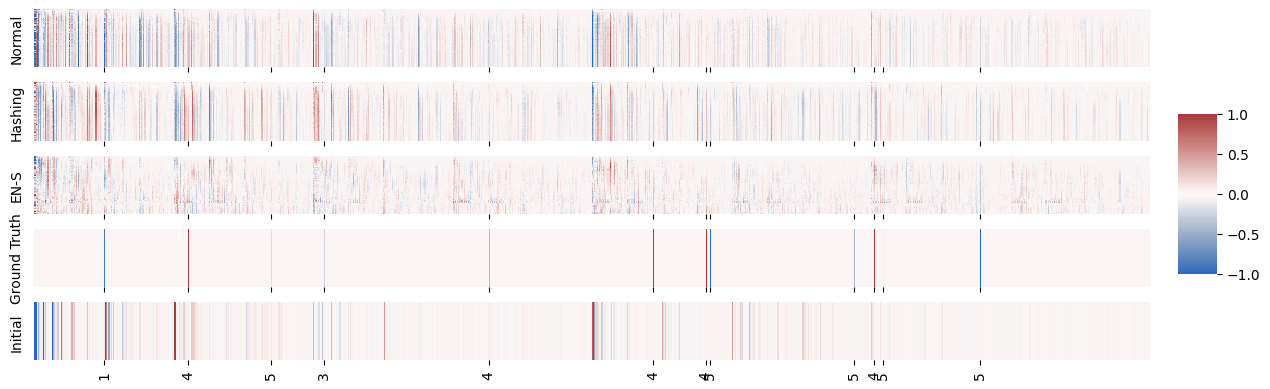

In [21]:
def normalize_spectrum(calculated_spectrum, target_spectrum):
    target_var = np.std(target_spectrum)
    return np.where(target_spectrum != 0, calculated_spectrum/target_spectrum, calculated_spectrum/target_var)

fig, axes = plt.subplots(5, 1, figsize=(13, 4), sharex=True)

ground_spectrum = np.vstack(dataset.get_fourier_spectrum()*((2**(test_n/2))/test_k)).reshape(1, -1)

data_norm = np.vstack(spectrums_norm)
data_hash = np.vstack(spectrums_hash)
data_EN_S = np.vstack(spectrums_EN_S)

data_range = 1
# np.max([np.abs(data_norm), np.abs(data_hash), np.abs(data_EN_S)])
cbar_ax = fig.add_axes([.91, .3, .03, .4])
sns.heatmap(data_norm, cmap="vlag", vmin=-data_range, vmax=data_range, ax=axes[0], cbar=True, cbar_ax=cbar_ax)
sns.heatmap(data_hash, cmap="vlag", vmin=-data_range, vmax=data_range, ax=axes[1], cbar=False)
sns.heatmap(data_EN_S, cmap="vlag", vmin=-data_range, vmax=data_range, ax=axes[2], cbar=False)
sns.heatmap(ground_spectrum, cmap="vlag", vmin=-data_range, vmax=data_range, ax=axes[3], cbar=False)
sns.heatmap(spectrums_norm[0].reshape(1, -1), cmap="vlag", vmin=-data_range, vmax=data_range, ax=axes[4], cbar=False)

freq_degrees = torch.sum(dataset.freq_f, axis=1).int().tolist()
for ax in axes:
    ax.set_xticks(dataset.get_int_freqs(), freq_degrees)
    ax.set_yticks([])
axes[0].set_ylabel("Normal")
axes[1].set_ylabel("Hashing")
axes[2].set_ylabel("EN-S")
axes[3].set_ylabel("Ground Truth")
axes[4].set_ylabel("Initial")
fig.tight_layout(rect=[0, 0, .9, 1])



[616 868 779 568 266  64 752 141 417 217 620 771]
[4, 5, 5, 4, 3, 1, 5, 4, 4, 5, 5, 4]
[64, 266, 141, 417, 568, 616, 771, 217, 620, 752, 779, 868]


<AxesSubplot: title={'center': 'EN-S'}>

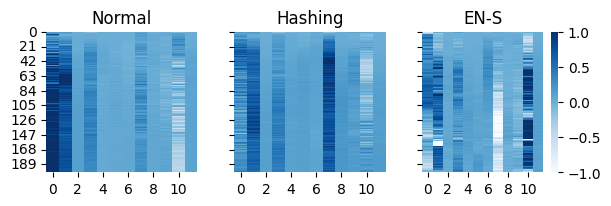

In [22]:
int_freqs = dataset.get_int_freqs()
print(int_freqs)
print(freq_degrees)
int_freqs = [x for _, x in sorted(zip(freq_degrees, int_freqs))]
print(int_freqs)


fig, axes = plt.subplots(1, 3, figsize=(6, 2), sharey=True)
fig.tight_layout()
axes[0].set_title("Normal")
axes[1].set_title("Hashing")
axes[2].set_title("EN-S")

data_range = 1
sns.heatmap(data_norm[:, int_freqs] / ground_spectrum[0, int_freqs], cmap="Blues", vmin=-data_range, vmax=data_range, ax=axes[0], cbar=False)
sns.heatmap(data_hash[:, int_freqs] / ground_spectrum[0, int_freqs], cmap="Blues", vmin=-data_range, vmax=data_range, ax=axes[1], cbar=False)
sns.heatmap(data_EN_S[:, int_freqs] / ground_spectrum[0, int_freqs], cmap="Blues", vmin=-data_range, vmax=data_range, ax=axes[2])


In [23]:
print(ground_spectrum[0, int_freqs])
print(spectrums_hash[99][int_freqs])
print(r2_score(ground_spectrum[0, int_freqs], spectrums_hash[99][int_freqs]))

[-0.87916215 -0.26419099  2.4505558   0.39319452 -2.10476176  2.21507517
  1.72962411  0.17711131 -1.21172619 -0.4410855  -0.09218725 -2.58832137]
[-0.31953332 -0.18888406  0.26930654  0.15686718 -0.2454123   0.3270823
  0.17847283  0.1607721  -0.25902998 -0.05354539  0.03017774 -0.362006  ]
0.2567167910652488


<AxesSubplot: >

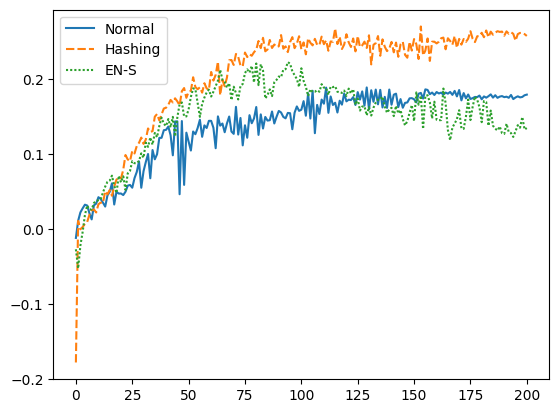

In [24]:
norm_diff = [r2_score(ground_spectrum[0, int_freqs], spectrums_norm[epoch][int_freqs]) for epoch in range(len(spectrums_norm))]
hash_diff = [r2_score(ground_spectrum[0, int_freqs], spectrums_hash[epoch][int_freqs]) for epoch in range(len(spectrums_hash))]
EN_S_diff = [r2_score(ground_spectrum[0, int_freqs], spectrums_EN_S[epoch][int_freqs]) for epoch in range(len(spectrums_EN_S))]

data = {"Normal": norm_diff, "Hashing": hash_diff, "EN-S": EN_S_diff}
sns.lineplot(data)